In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import ROOT
import shapely

plt.rcParams["figure.figsize"] = (7, 12*7/8)


In [12]:
mpl.rcParams.update({'font.size': 20})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 20}) 
mpl.rcParams.update({'ytick.labelsize': 20}) 

In [13]:
#minimum distance to the beampipe
clearance=0.5

#gap between left and right halves
LRgap=0.4




#new version... calculate based on the shadow of the ECal
ECAL_clearance_TB=2.3
ECAL_clearance_L=2.2
ECAL_clearance_R=4.1

ECAL_support_width=0.5

flange_radius=(4.3707*2.54)/2
flange_width=(5.9919)*2.54


print(f"ECal hole size: {flange_radius*2+ECAL_clearance_TB-ECAL_support_width*2:.2f} x {flange_width+ECAL_clearance_L+ECAL_clearance_R-2*ECAL_support_width} cm^2")
#Moliere_radius=2.1
#nMol=2
#outer_radius = (flange_radius+ECAL_clearance)*320/194+Moliere_radius*nMol  #two moliere radii from the edge of the shadow of the ECAL endcap
#horizontal_extension=(flange_width-2*flange_radius)*320/194
#print(f"outer radius is {outer_radius:.2f}")
#print(f"horizontal_extension is {horizontal_extension:.2f}")

det_height=30
det_width=40


#position="pre-flange"
position="HCAL+10cm"

if position == "pre-flange":
    #radii and positions of holes
    R1=4.281
    X1=0
    R2=1.574
    X2=6.825
    z_downstream=-269.72 # downstream face, at flange
elif position == "pre-HCAL":
    #radii and positions of holes
    #R1=4.4922
    #X1=0
    #R2=2.223
    #X2=8.2406
    z_downstream=-329.6 # downstream face, in front of the HCal
    X1=0
    R1=4.281+(4.21-4.281)*(z_downstream-(-269.72))/14.21
    R2=1.574+(1.519-1.574)*(z_downstream-(-269.72))/14.21
    X2=6.825+(6.407-6.825)*(z_downstream-(-269.72))/14.21
    print(f"R1={R1:.3f}\nR2={R2:.3f}\nX1={X1:.3f}\nX2={X2:.3f}")
elif position == "HCAL+10cm":
    #radii and positions of holes
    #R1=4.4922
    #X1=0
    #R2=2.223
    #X2=8.2406
    z_downstream=-329.6+10 # downstream face, with 10 cm space in front of the HCa
    X1=0
    R1=4.281+(4.21-4.281)*(z_downstream-(-269.72))/14.21
    R2=1.574+(1.519-1.574)*(z_downstream-(-269.72))/14.21
    X2=6.825+(6.407-6.825)*(z_downstream-(-269.72))/14.21
    print(f"R1={R1:.3f}\nR2={R2:.3f}\nX1={X1:.3f}\nX2={X2:.3f}")

ECal hole size: 12.40 x 20.519426000000003 cm^2
R1=4.530
R2=1.767
X1=0.000
X2=8.292


In [14]:
def rect(x1,y1, x2,y2):
    return shapely.Polygon([(x1,y1), (x2,y1), (x2, y2),(x1,y2), (x1,y1)])

In [15]:
phi=np.linspace(-np.pi, np.pi, 49)
pipe1=shapely.Polygon(zip(R1*np.cos(phi), R1*np.sin(phi)))
pipe2=shapely.Polygon(zip(R2*np.cos(phi)+X2, R2*np.sin(phi)))

hole=pipe1.buffer(clearance) | pipe2.buffer(clearance)
#now for the flat extension:
hole |=rect(0, -R2-clearance, X2, R2+clearance)

rect1 = rect(-det_height/2-LRgap/2, -det_height/2, det_width-det_height/2+LRgap/2, det_height/2)
both_halves=rect1 \
        -hole - rect(-LRgap/2, -det_height/2, LRgap/2, det_height/2)
left_half = both_halves.geoms[0]
right_half = both_halves.geoms[1]



mu=0.000308+-3.14e-06


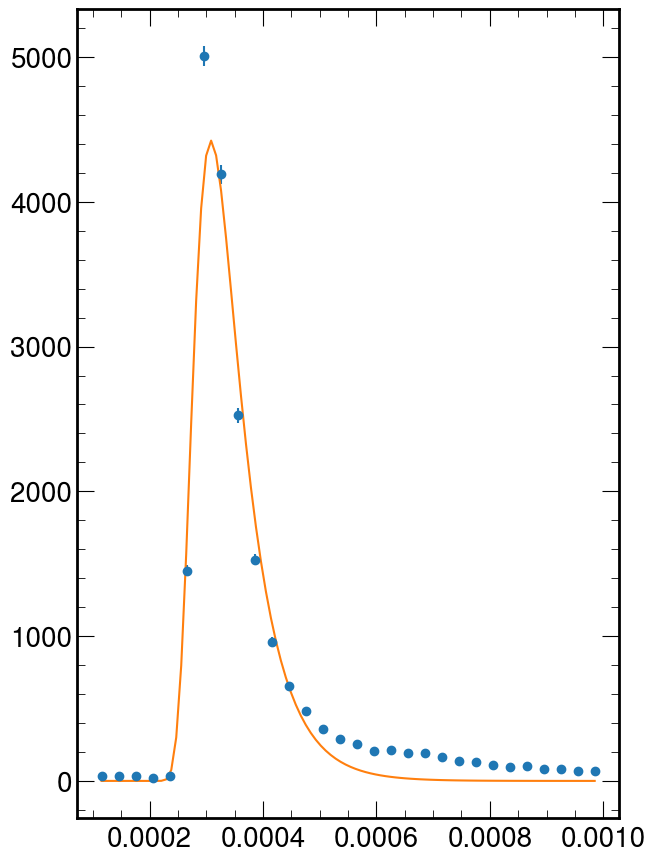

In [16]:
def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

import uproot as ur
events = ur.open(f'for_3D/insert_sim_mu-_5GeV_theta_178.85-178.85deg.edm4hep.root:events')
#events = ur.open(f'insert_sim_mu-_18GeV_theta_178-178deg.edm4hep.root:events')
arrays_sim = events.arrays()
all_energies=[]
for event in range(len(arrays_sim)):
    all_energies += list(arrays_sim['BackwardsEcalInsertHits.energy'][event,:])
h,x=np.histogram(all_energies, bins=30, range=(0.0001, 0.001))

bc=(x[1:]+x[:-1])/2
p0=[100,np.mean(all_energies), np.std(all_energies)*.8]


#slc=(h>0) 
from scipy.optimize import curve_fit
coeff, var_matrix = curve_fit(Landau, bc, h, p0=p0,
                         sigma=np.sqrt(h))
plt.subplots(1,1)
plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='')

x=np.linspace(bc[0], bc[-1], 100)
plt.plot(x, Landau(x,*coeff))
print(f"mu={coeff[1]:.3}+-{np.sqrt(var_matrix[1][1]):.3}")
plt.show()

In [21]:
def plots3d(input_file, title, output_file, MIP=0.000308, event=0,scale_canvas=0.8):
    from mpl_toolkits.mplot3d import Axes3D
    fig=plt.figure(figsize=(8*scale_canvas, 16*scale_canvas))
    ax1 = fig.add_subplot(211, projection='3d',azim=45, elev=30)
    

    z_upstream=z_downstream+(.35+0.08+.2)*20+.35

    arg=dict(color='k')
    thick=1.5
    thin=0.7

    for z,lw in (z_downstream,thin), (z_upstream, thick):
        #left
        for shape in rect1, hole:
            plt.plot([z]*len(shape.exterior.xy[0]), *shape.exterior.xy, **arg, lw=lw)
    #edges along corners
    for xy in (-LRgap/2-det_height/2, -det_height/2),(-LRgap/2-det_height/2, det_height/2),\
                (LRgap/2+det_width-det_height/2, -det_height/2),(LRgap/2+det_width-det_height/2, det_height/2):
        xi=xy[0]
        yi=xy[1]
        lw=thick if (yi>10) or (xi>20) else thin
        plt.plot([z_upstream, z_downstream], (xi, xi), (yi, yi), **arg, lw=lw)


    #now show the hits:
    import uproot as ur

    my_cmap = plt.get_cmap('viridis')
    events = ur.open(f'{input_file}:events')
    arrays_sim = events.arrays()
    print(arrays_sim['MCParticles.PDG'])


    E=arrays_sim['BackwardsEcalInsertHits.energy'][event,:]
    x=arrays_sim['BackwardsEcalInsertHits.position.x'][event,:]
    y=arrays_sim['BackwardsEcalInsertHits.position.y'][event,:]
    z=arrays_sim['BackwardsEcalInsertHits.position.z'][event,:]

    slc=E/MIP>0.1
    sctt3d = ax1.scatter3D(z[slc]/10, x[slc]/10, y[slc]/10,
                    alpha = 0.8,
                    c = E[slc]/MIP,
                    s=40*E[slc]/np.max(E),
                    cmap = my_cmap,
                    norm=mpl.colors.LogNorm(vmin=0.5, vmax=70),
                    marker ='H')
    plt.xlim(-322,-304) #z
    plt.ylim(-16, 26) #x
    plt.gca().set_zlim(-16, 16) #y
    
    X,Y=hole.exterior.xy
    Z=np.array([np.array([z_downstream]*len(X)),np.array([z_upstream]*len(X))])
    X=np.array([X,X])
    Y=np.array([Y,Y])
    ax1.plot_surface(Z,X, Y, color='0.7',
                       linewidth=0, antialiased=True, alpha=0.15)
    
#     plt.xlim(-325,-295) #z
#     plt.ylim(-10, 20) #x
#     plt.gca().set_zlim(-15, 15) #y

    plt.gca().set_xlabel("\nz [cm]")
    plt.gca().set_ylabel("\nx [cm]")
    plt.gca().set_zlabel("y [cm]")
    #plt.gca().axis('off')
    plt.title(title)
    
    #plt.savefig(output_file)
    
    #plt.gca().set_anchor("SW")
    plt.gca().set_box_aspect((18,42,32), zoom=1.2)
    
    
    #xz view
    ax2 = fig.add_subplot(413)
    sctt = ax2.scatter(x[slc]/10, z[slc]/10,
                    alpha = 0.8,
                    c = E[slc]/MIP,
                    s=40*E[slc]/np.max(E),
                    cmap = my_cmap,
                    norm=mpl.colors.LogNorm(vmin=0.5, vmax=70),
                    marker ='H')
    plt.gca().set_xlabel("x [cm]")
    plt.gca().set_ylabel("z [cm]")
    plt.gca().invert_yaxis()
    
    
    for z,lw in (z_downstream,thick), (z_upstream, thick):
        
        for shape in rect1, hole:
            plt.plot(shape.exterior.xy[0],[z]*len(shape.exterior.xy[0]), **arg, lw=lw)
    #edges along corners
    for xy in (-LRgap/2-det_height/2, -det_height/2),(-LRgap/2-det_height/2, det_height/2),\
                (LRgap/2+det_width-det_height/2, -det_height/2),\
                (LRgap/2+det_width-det_height/2, det_height/2),\
                (-R1-clearance, 0), (np.sqrt((R1+clearance)**2-(R2+clearance)**2), 0), (R2+X2+clearance,0):
        xi=xy[0]
        yi=xy[1]
        lw=thick if abs(xi)>12 else thin
        plt.plot((xi, xi), [z_upstream, z_downstream], **arg, lw=lw)
    
    xlim, ylim=(-17, 27),(-305, -322)
    plt.ylim(*ylim)
    plt.xlim(*xlim)
    
    #set aspect ratio to 1
    ratio = 1.0
#     x_left, x_right = ax.get_xlim()
#     y_low, y_high = ax.get_ylim()
#     a=abs((x_right-x_left)/(y_low-y_high))*ratio
#     print(a)
    ax2.set_aspect(1)
    
    plt.gca().add_patch(mpl.patches.Rectangle((-R1-clearance, z_downstream), R1+2*clearance+X2+R2, z_upstream-z_downstream,
                                             color='0.7', zorder=-10, alpha=0.3))
    
    
    E=arrays_sim['BackwardsEcalInsertHits.energy'][event,:]
    x=arrays_sim['BackwardsEcalInsertHits.position.x'][event,:]
    y=arrays_sim['BackwardsEcalInsertHits.position.y'][event,:]
    z=arrays_sim['BackwardsEcalInsertHits.position.z'][event,:]
    
    #yz view
    ax3 = fig.add_subplot(414, aspect=1, sharey=ax2)
    ax2.sharey(ax3)
    sctt = ax3.scatter(y[slc]/10, z[slc]/10,
                    alpha = 0.8,
                    c = E[slc]/MIP,
                    s=40*E[slc]/np.max(E),
                    cmap = my_cmap,
                    norm=mpl.colors.LogNorm(vmin=0.5, vmax=70),
                    marker ='H')
    plt.gca().set_xlabel("y [cm]")
    plt.gca().set_ylabel("z [cm]")
    plt.gca().invert_yaxis()
    
    for z,lw in (z_downstream,thick), (z_upstream, thick):
        
        for shape in rect1, hole:
            plt.plot(shape.exterior.xy[1],[z]*len(shape.exterior.xy[0]), **arg, lw=lw)
    #edges along corners
    for xy in (-LRgap/2-det_height/2, -det_height/2),(-LRgap/2-det_height/2, det_height/2),\
                (LRgap/2+det_width-det_height/2, -det_height/2),\
                (LRgap/2+det_width-det_height/2, det_height/2),\
                (0,-R1-clearance), (0,(R2+clearance)), \
                (0,R1+clearance), (0,-(R2+clearance)):
        xi=xy[0]
        yi=xy[1]
        lw=thick if abs(yi)>10 else thin
        plt.plot((yi, yi), [z_upstream, z_downstream], **arg, lw=lw)
    
    plt.gca().add_patch(mpl.patches.Rectangle((-R1-clearance, z_downstream), 2*(R1+clearance), z_upstream-z_downstream,
                                             color='0.7', zorder=-10, alpha=0.3))
    
    xlim, ylim=(-22, 22),(-305, -322)
    plt.ylim(*ylim)
    plt.xlim(*xlim)
    
    
    #set aspect ratio to 1
#     ratio = 1.0
#     x_left, x_right = ax.get_xlim()
#     y_low, y_high = ax.get_ylim()
#     a=abs((x_right-x_left)/(y_low-y_high))*ratio
    #print(a)
    ax3.set_aspect(1)
    ax2.set_zorder(10)
    ax2.set_facecolor('w')
    
    ax2.set_title("xz")
    ax3.set_title("yz")
    #plt.subplots_adjust(wspace=0)
    cax=fig.add_subplot()
    cax.set_position([0.9, 0.55, 0.05, 0.45])
    cb = fig.colorbar(sctt3d, cax=cax, shrink = 1, aspect = 20)
    cb.set_label("Hit energy [MIP]")
    
    left=-0.05; bottom=0.47; width=.83; height=0.62
    ax1.set_position([left, bottom, width, height])
    #help(cb)
    #help(ax2.get_position())
    #left, bottom, width, height=ax2.get_position()
    ax2.set_position([0,0.26, 1,0.25])
    ax3.set_position([0,0, 1,0.25])
    #plt.tight_layout()
    
    plt.savefig(output_file)
    plt.show()

[[11, 2212, 11], [11, 2212, 11], [11, 2212, ... 11], [11, 2212, 11], [11, 2212, 11]]


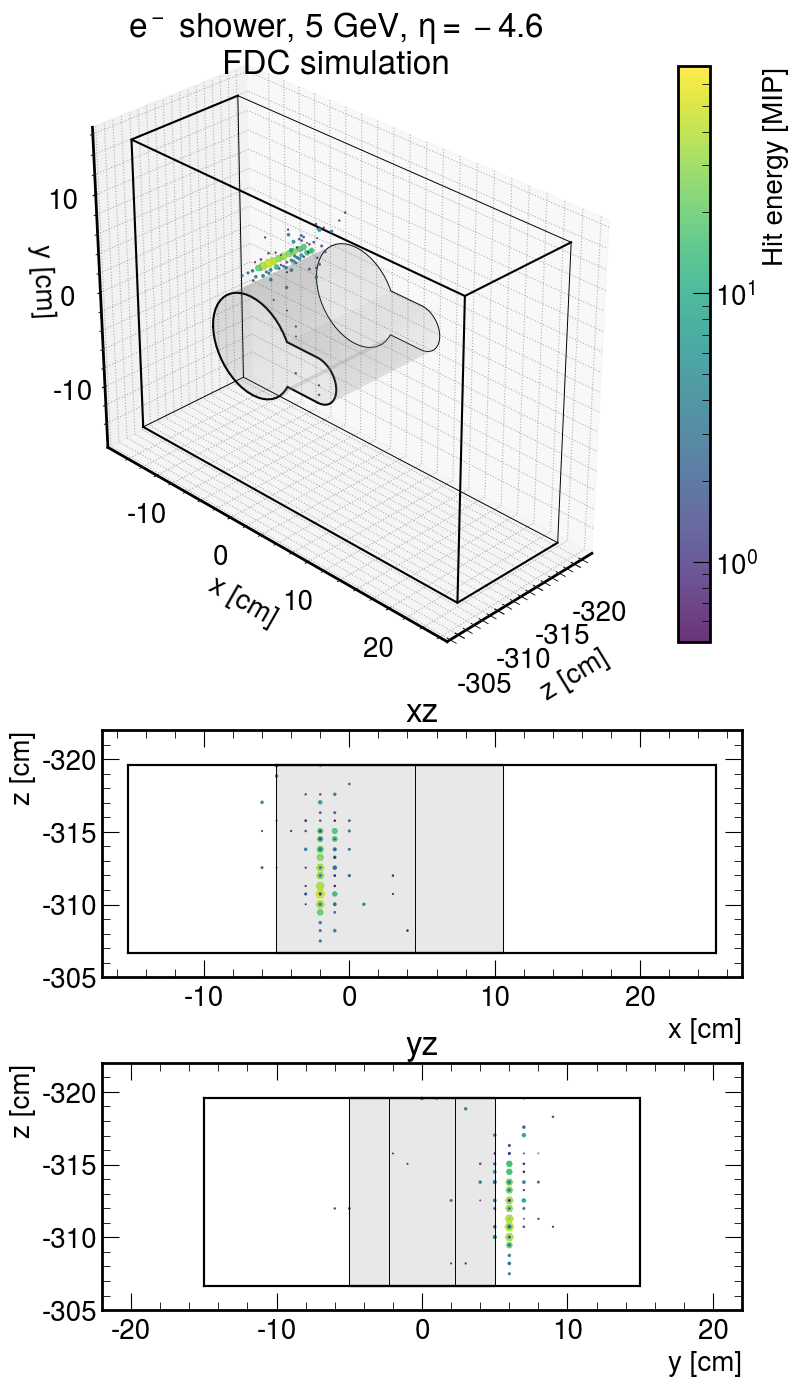

In [22]:
plots3d("for_3D/insert_sim_e-_5GeV_theta_178.85-178.85deg.edm4hep.root", "$e^-$ shower, 5 GeV, $\\eta=-4.6$\nFDC simulation", "images/electron_shower.pdf", event=2)

[[11, 2212, -211], [11, 2212, -211], [11, ... [11, 2212, -211], [11, 2212, -211]]


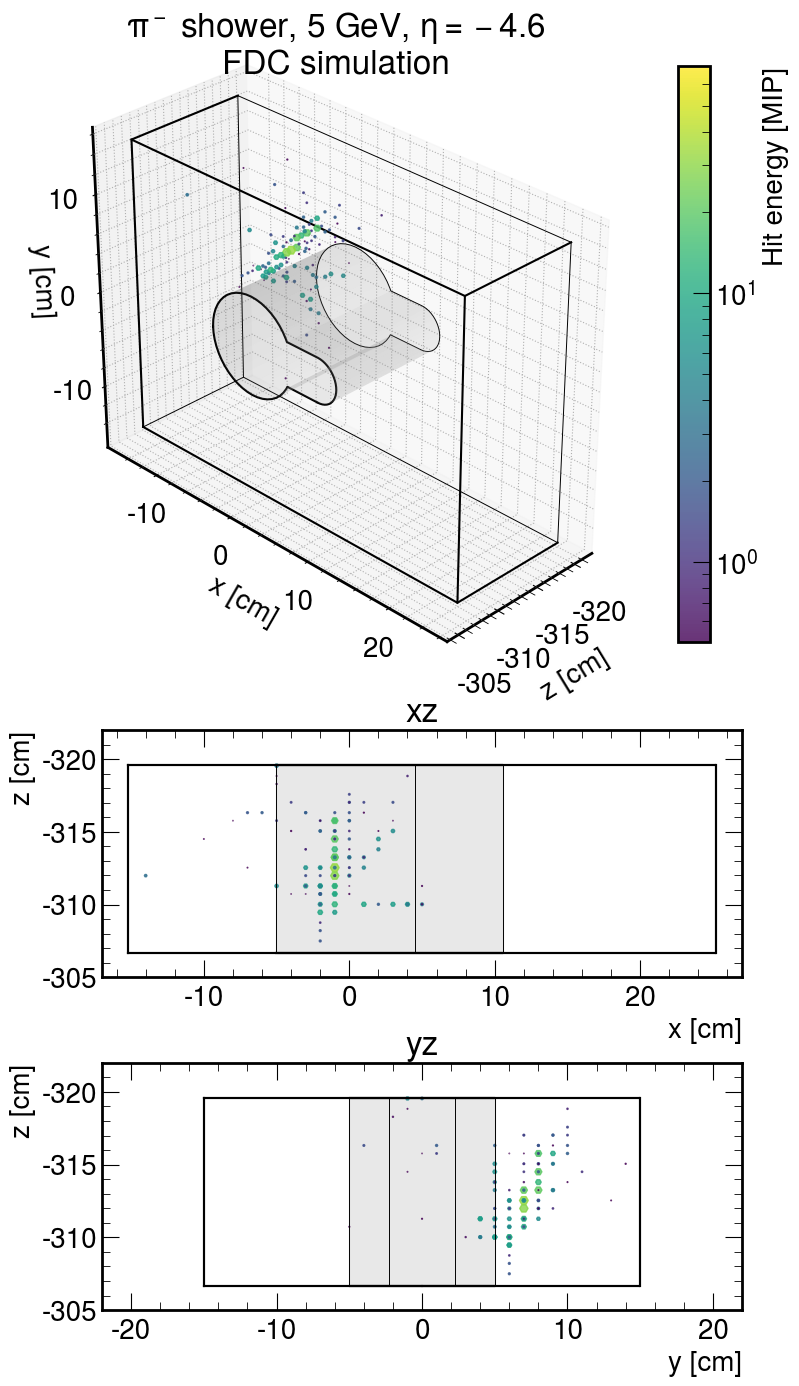

In [23]:
plots3d("for_3D/insert_sim_pi-_5GeV_theta_178.85-178.85deg.edm4hep.root", "$\pi^-$ shower, 5 GeV, $\\eta=-4.6$\nFDC simulation", "images/pion_shower.pdf",event=5)

[[11, 2212, 22], [11, 2212, 22], [11, 2212, ... 22], [11, 2212, 22], [11, 2212, 22]]


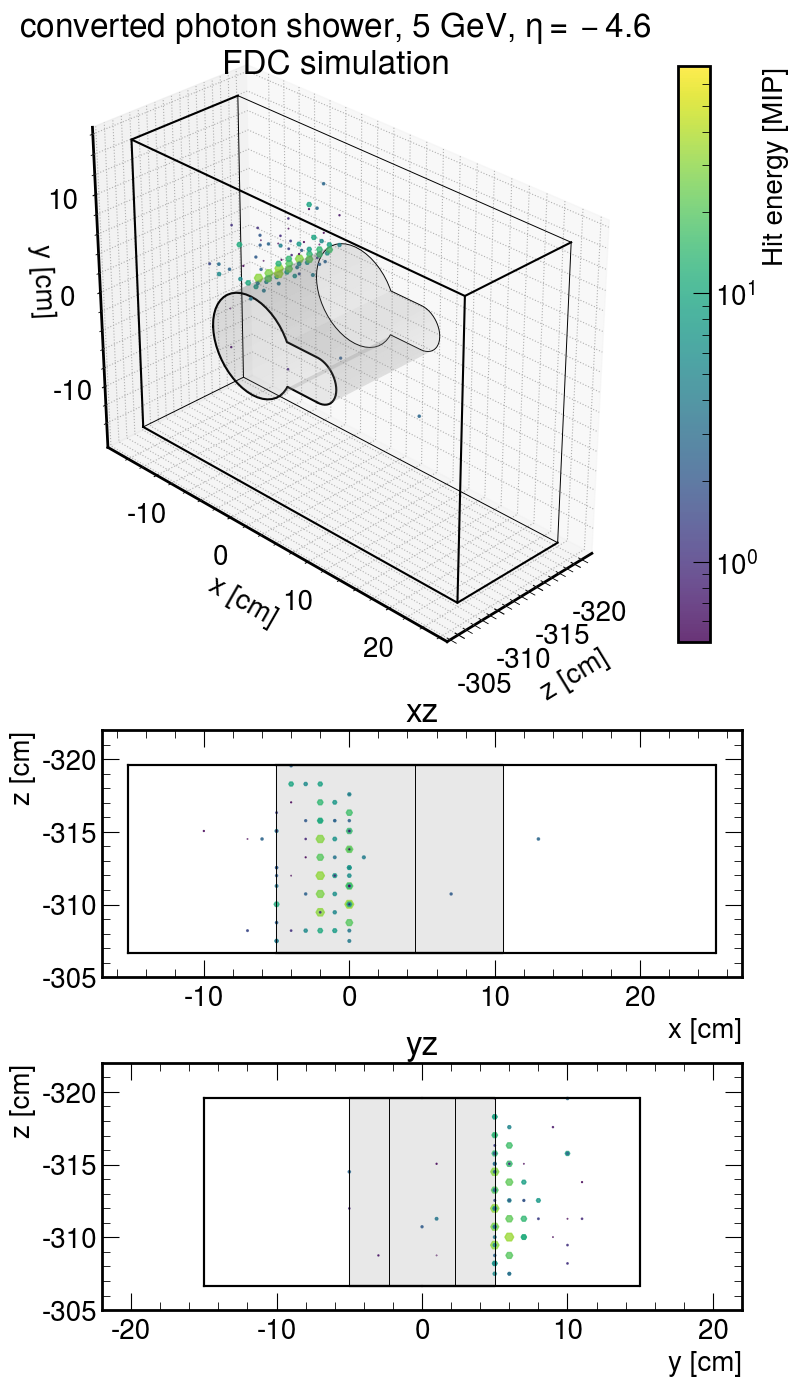

In [24]:
#plots3d("for_3D/shower_insert_sim_e-_5GeV_theta_178.85-178.85deg.edm4hep.root", 
#        "converted photon shower, 5 GeV, $\\eta=-4.6$\nFDC simulation", "images/photon_conv_shower.pdf", 
#        event=21)
plots3d("for_3D/insert_sim_gamma_5GeV_theta_178.85-178.85deg.edm4hep.root", 
        "converted photon shower, 5 GeV, $\\eta=-4.6$\nFDC simulation", "images/photon_conv_shower.pdf", 
        event=1)
